# Dynamic Risk Budgeting

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import edhec_risk_kit as erk

In [3]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
prices_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [4]:
rets_eq = prices_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixed_mix_allocator, w1=0.7)

pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)
], axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.94,1.74
std,0.00,0.97,0.59
p_breach,NaN,0.03,0.01
e_short,NaN,0.12,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


We are going to fix the breaches.

The breaches are happening because my allocator is blind to the floor (0.75). So it will not be able to meet the requirement that I should have at least 0.75 cents on the dollar at the end of the 10 years.

In [9]:
np.repeat((3,3), 5)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [10]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc,
                          allocator=erk.floor_allocator, floor=0.75,
                          zc_prices=zc_prices[1:])

pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floort75", floor=0.75)
], axis=1).round(2)

,ZC,Eq,70/30,Floort75
mean,1.34,1.94,1.74,1.92
std,0.00,0.97,0.59,0.97
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.12,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [13]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc,
                          allocator=erk.floor_allocator, 
                          floor=0.75,
                          zc_prices=zc_prices[1:], m=1)
rets_floot75m5 = erk.bt_mix(rets_eq, rets_zc,
                          allocator=erk.floor_allocator, 
                          floor=0.75,
                          zc_prices=zc_prices[1:], m=5)

pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floot75, name="Floort75", floor=0.75),
    erk.terminal_stats(rets_floor75m1, name="Floort75m1", floor=0.75),
    erk.terminal_stats(rets_floot75m5, name="Floort75m5", floor=0.75)
], axis=1).round(4)

,ZC,Eq,70/30,Floort75,Floort75m1,Floort75m5
mean,1.3433,1.9421,1.7402,1.9171,1.6097,1.9273
std,0.0000,0.9680,0.5874,0.9732,0.4271,0.9769
p_breach,NaN,0.0330,0.0066,NaN,NaN,NaN
e_short,NaN,0.1161,0.0844,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


# Risk Budgeting with Drawdown Constraints

In [14]:
cash_rate = 0.02
monthly_cash_return = (1+cash_rate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cash_return, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floot75, name="Floort75", floor=0.75),
    erk.terminal_stats(rets_floor75m1, name="Floort75m1", floor=0.75),
    erk.terminal_stats(rets_floot75m5, name="Floort75m5", floor=0.75),
    erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)
], axis=1).round(4)

,ZC,Eq,70/30,Floort75,Floort75m1,Floort75m5,MaxDD25
mean,1.3433,1.9421,1.7402,1.9171,1.6097,1.9273,1.6115
std,0.0000,0.9680,0.5874,0.9732,0.4271,0.9769,0.5331
p_breach,NaN,0.0330,0.0066,NaN,NaN,NaN,NaN
e_short,NaN,0.1161,0.0844,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
erk.summary_stats(rets_maxdd25)["max drawdown"].head()

0   -0.179304
1   -0.188795
2   -0.155097
3   -0.176754
4   -0.149315
Name: max drawdown, dtype: float64

In [17]:
erk.summary_stats(rets_maxdd25)["max drawdown"].min()

-0.23226612454226067

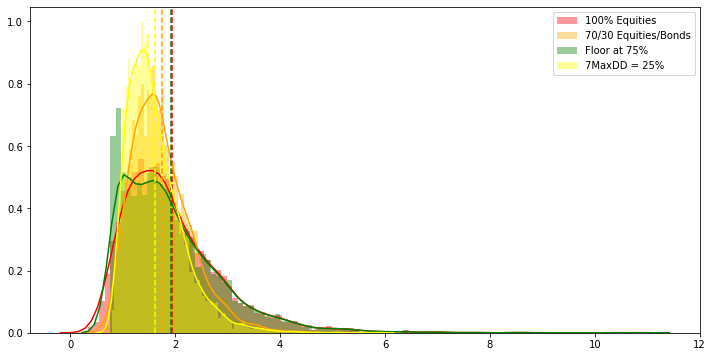

In [20]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floot75)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")

sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")

sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")

sns.distplot(tv_maxdd25, color="yellow", label="7MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend()

# Drawdown Constraint with Historical Data

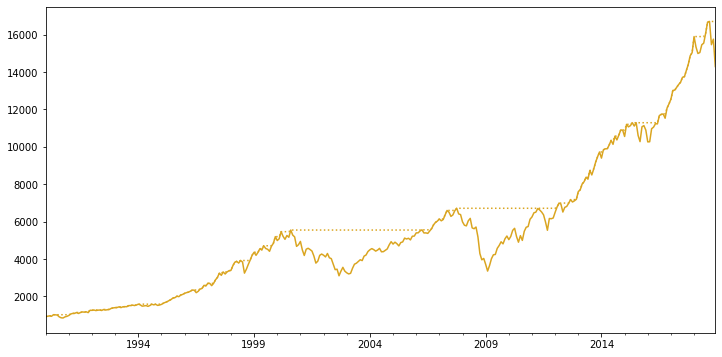

In [22]:
rets_tmi = erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown_df(rets_tmi)
ax = dd_tmi["wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["peaks"].plot(ax=ax, ls=":", color="goldenrod")

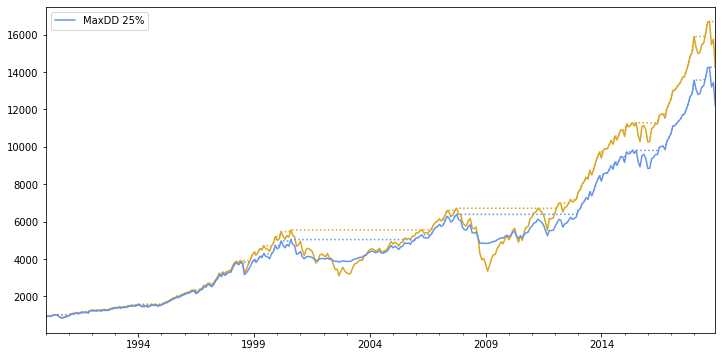

In [23]:
cash_rate = 0.03
monthly_cash_return = (1+cash_rate)**(1/12) - 1

# Historical data instead of simulated data
rets_cash = pd.DataFrame(data=monthly_cash_return, index=rets_tmi.index, columns=[0])
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi),
                          rets_cash, allocator=erk.drawdown_allocator, 
                          maxdd=0.25, m=5)
dd_25 = erk.drawdown_df(rets_maxdd25[0])

ax = dd_tmi["wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market")
dd_tmi["peaks"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["peaks"].plot(ax=ax, color="cornflowerblue", ls=":")

In [24]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")],
                           axis=1))

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212


In the following questions, we will be working with three bonds:

* B1 is a 15 Year Bond with a Face Value of \\$1000 that pays a 5% coupon semi-annually (2 times a year)
* B2 is a 5 Year Bond with a Face value of \\$1000 that pays a 6% coupon quarterly (4 times a year)
* B3 is a 10 Year Zero-Coupon Bond with a Face Value of \\$1000 (Hint: you can still use the `erk.bond_cash_flows()` and `erk.bond_price()` by setting the coupon amount to 0% and coupons_per_year to 1) 

Assume the yield curve is flat at 5%. Duration refers to Macaulay Duration

Hint: the macaulay_duration function gives as output the duration expressed in periods and not in years. If you want to get the yearly duration you need to divide the duration for coupons_per_year;

e.g.: `duarion_B2 = erk.macaulay_duration(flows_B2, 0.05/4)/4`

In [55]:
b1 = erk.bond_price(15, 1000, 0.05, 2, 0.05)
b2 = erk.bond_price(5, 1000, 0.06, 4, 0.05)
b3 = erk.bond_price(10, 1000, 0.0, 1, 0.05)

pd.concat([b1.rename("B1"),b2.rename("B2"),b3.rename("B3")], axis="columns")

,B1,B2,B3
0,1000.0,1043.99829,613.913254


In [56]:
b1_flows = erk.bond_cash_flows(15, 1000, 0.05, 2)
b1_flows.index = b1_flows.index/2

b2_flows = erk.bond_cash_flows(5, 1000, 0.06, 4)
b2_flows.index = b2_flows.index/4

b3_flows = erk.bond_cash_flows(10, 1000, 0.0, 1)

b1_macaulay = erk.macaulay_duration(b1_flows, 0.05)
b2_macaulay = erk.macaulay_duration(b2_flows, 0.05)
b3_macaulay = erk.macaulay_duration(b3_flows, 0.05)

In [57]:
b1_macaulay

10.742333260961377

In [58]:
b2_macaulay

4.374877036571144

In [59]:
b3_macaulay

10.0

In [66]:
liabilities = pd.Series(data=[100_000, 200_000, 300_000],
                        index=[3,5,10])
liabilities

3     100000
5     200000
10    300000
dtype: int64

In [67]:
erk.macaulay_duration(liabilities, 0.05)

6.750917852744651

In [72]:
(1 - erk.match_durations(liabilities, b1_flows, b2_flows, 0.05))*100

62.68461482197243

In [71]:
erk.match_durations(liabilities, b2_flows, b1_flows, 0.05) * 100

62.68461482197243

In [75]:
(1 - erk.match_durations(liabilities, b1_flows, b3_flows, 0.05)) * 100

537.6851096564827

In [76]:
erk.match_durations(liabilities, b2_flows, b3_flows, 0.05)

0.5776019774818993